In [164]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 実験

> Test

In [165]:
#|default_exp Exper

In [166]:
#| hide
#| export
import jax.numpy as jnp
import jax.random as jrd
import jax
from jaxtyping import Float, Int, Array, PRNGKeyArray
from KalmanPaper import gen, EKF, VA, simple
from matplotlib import pyplot as plt
from typing import Tuple
from functools import partial

In [167]:
#| export
@partial(jax.jit, static_argnames=['N', 'T'])
def exper(
    key: PRNGKeyArray,
    N: int,
    T: int,
    G: Float[Array, "{N} {N}"],
    w0: Float[Array, "{N}"],
    Sigma: Float[Array, "{N} {N}"],
    P0: Float[Array, "{N} {N}"], 
    propy1: Float,
    epsilon: Float =2**(-16)
):
  key_w, key_xy = jrd.split(key, 2)
  W = gen.gen_w(key_w, N, T, G, w0)
  X, Y = gen.gen_xy(key_xy, N, T, Sigma, W, propy1)
  Wtt_EKF, Ptt_EKF = EKF.EKF(N, T, X, Y, G, w0, P0)
  Wtt_VA, Ptt_VA, Xit_VA = VA.VApre(N, T, X, Y, G, w0, P0)
  Wtt_EM, Ptt_EM, Xit_EM = VA.VAEM(N, T, X, Y, G, w0, P0, epsilon)
  
  return X, Y, W, (Wtt_EKF, Ptt_EKF), (Wtt_VA, Ptt_VA, Xit_VA), (Wtt_EM, Ptt_EM, Xit_EM)

In [458]:
N=2
G = 1/2**9 * jnp.identity(N, dtype=jnp.float32)
Sigma = 10* jnp.identity(N, dtype=jnp.float32)
w0 = 0*jnp.ones((N,), dtype=jnp.float32)
propy1 = 0.5

X, Y, W, \
  (Wtt_EKF, Ptt_EKF), \
    (Wtt_VA, Ptt_VA, Xit_VA), \
      (Wtt_EM, Ptt_EM, Xit_EM) \
        = exper(
  key=jrd.PRNGKey(422), # 822 522
  N=N, 
  T=500, 
  G=G,
  w0=w0,
  Sigma=Sigma,
  P0=G,
  propy1=propy1)

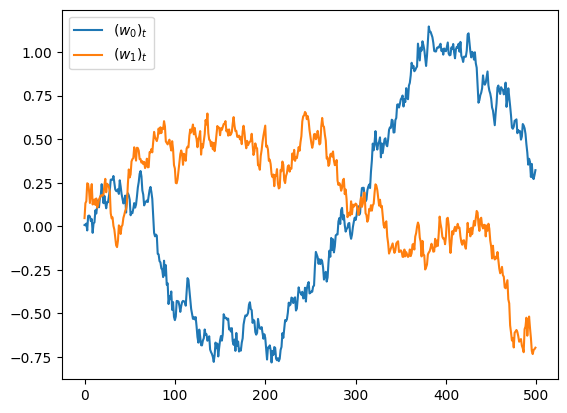

In [459]:
plt.plot(W[:,0], label=r"$(w_0)_t$")
plt.plot(W[:,1], label=r"$(w_1)_t$")
plt.legend()

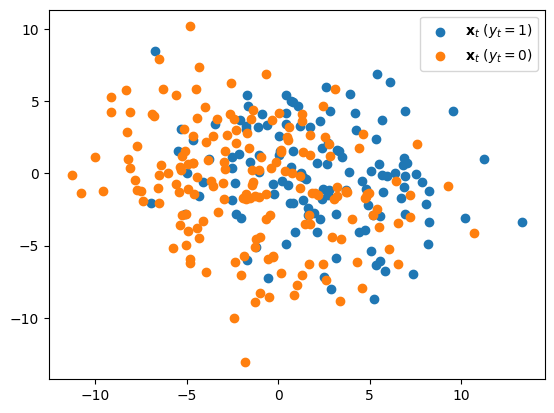

In [460]:
plt.scatter(X[Y==1][100:300,0], X[Y==1][100:300,1], label=r"$\mathbf{x}_t\ (y_t=1)$")
plt.scatter(X[Y==0][100:300,0], X[Y==0][100:300,1], label=r"$\mathbf{x}_t\ (y_t=0)$")
plt.legend()

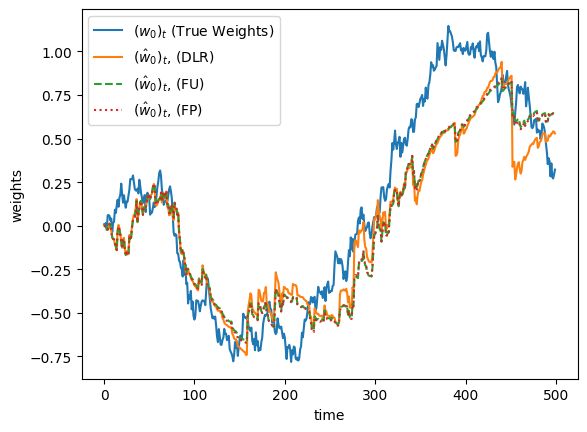

In [471]:
plt.plot(W[:,0], label=r"$(w_0)_t$ (True Weights)")
plt.plot(Wtt_EKF[:,0], "-", label=r"$(\hat{w}_0)_t$, (DLR)")
plt.plot(Wtt_VA[:,0], "--", label=r"$(\hat{w}_0)_t$, (FU)")
plt.plot(Wtt_EM[:,0], ":", label=r"$(\hat{w}_0)_t$, (FP)")
plt.xlabel("time")
plt.ylabel("weights")
plt.legend()

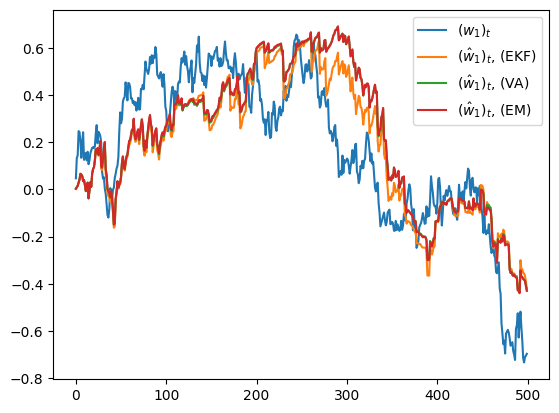

In [463]:
plt.plot(W[:,1], label=r"$(w_1)_t$")
plt.plot(Wtt_EKF[:,1], label=r"$(\hat{w}_1)_t$, (EKF)")
plt.plot(Wtt_VA[:,1], label=r"$(\hat{w}_1)_t$, (VA)")
plt.plot(Wtt_EM[:,1], label=r"$(\hat{w}_1)_t$, (EM)")
plt.legend()

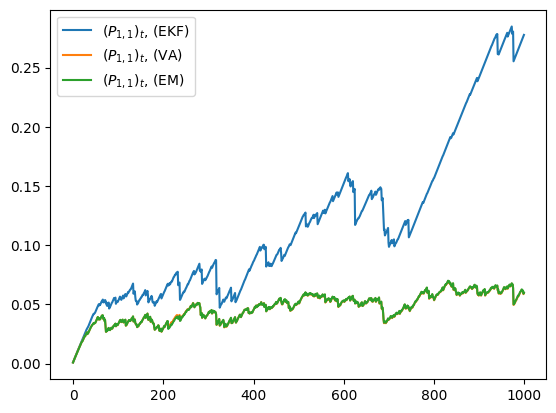

In [358]:
plt.plot(Ptt_EKF[:,0,0], label=r"$(P_{1,1})_t$, (EKF)")
plt.plot(Ptt_VA[:,0,0], label=r"$(P_{1,1})_t$, (VA)")
plt.plot(Ptt_EM[:,0,0], label=r"$(P_{1,1})_t$, (EM)")
plt.legend()

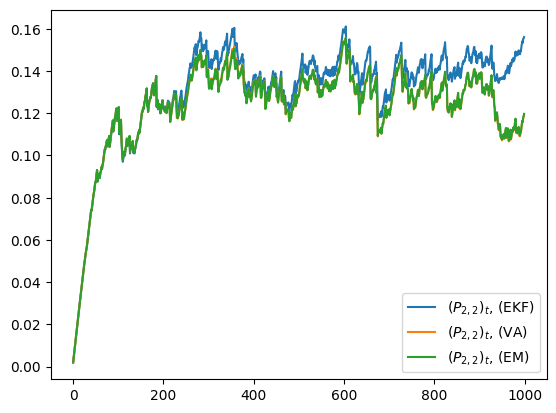

In [174]:
plt.plot(Ptt_EKF[:,1,1], label=r"$(P_{2,2})_t$, (EKF)")
plt.plot(Ptt_VA[:,1,1], label=r"$(P_{2,2})_t$, (VA)")
plt.plot(Ptt_EM[:,1,1], label=r"$(P_{2,2})_t$, (EM)")
plt.legend()

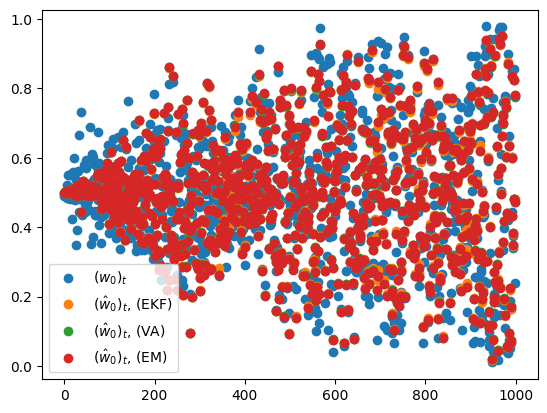

In [175]:
plt.plot(simple.losi(jnp.sum(W*X, axis=1)), 'o', label=r"$(w_0)_t$")
plt.plot(simple.losi(jnp.sum(Wtt_EKF*X, axis=1)), 'o', label=r"$(\hat{w}_0)_t$, (EKF)")
plt.plot(simple.losi(jnp.sum(Wtt_VA*X, axis=1)), 'o', label=r"$(\hat{w}_0)_t$, (VA)")
plt.plot(simple.losi(jnp.sum(Wtt_EM*X, axis=1)), 'o', label=r"$(\hat{w}_0)_t$, (EM)")
plt.legend()

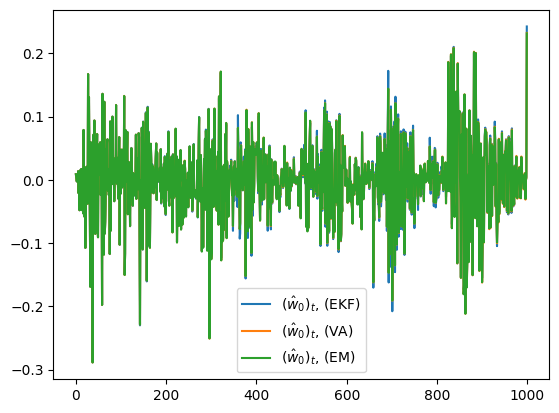

In [176]:
true_line = simple.losi(jnp.sum(W*X, axis=1))
plt.plot(simple.losi(jnp.sum(Wtt_EKF*X, axis=1)) - true_line, label=r"$(\hat{w}_0)_t$, (EKF)")
plt.plot(simple.losi(jnp.sum(Wtt_VA*X, axis=1)) - true_line, label=r"$(\hat{w}_0)_t$, (VA)")
plt.plot(simple.losi(jnp.sum(Wtt_EM*X, axis=1)) - true_line, label=r"$(\hat{w}_0)_t$, (EM)")
plt.legend()

In [177]:
print(jnp.sum((simple.losi(jnp.sum(Wtt_EKF*X, axis=1)) - true_line)**2))
print(jnp.sum((simple.losi(jnp.sum(Wtt_VA*X, axis=1)) - true_line)**2))
print(jnp.sum((simple.losi(jnp.sum(Wtt_EM*X, axis=1)) - true_line)**2))

3.3652086
3.3046522
3.29402


In [178]:
#| hide
import nbdev; nbdev.nbdev_export()